In [ ]:
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# ML tools
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


In [2]:
df = pd.read_csv("final_dataset.csv")

print(df.head())
print(df.info())


    City                     Date   PM2.5    PM10     NO     NO2    NOx  \
0  HR023  2018-11-12 00:00:00.000  238.43  348.91   3.25   78.95  44.63   
1  HR023  2018-11-13 00:00:00.000  284.83  427.40  19.98  112.54  76.15   
2  HR023  2018-11-14 00:00:00.000  150.41  214.16   6.35   96.17  56.30   
3  HR023  2018-11-15 00:00:00.000  106.11  154.36   7.36   77.52  47.21   
4  HR023  2018-11-16 00:00:00.000  146.23  211.34   2.01   60.29  33.65   

     NH3    CO    SO2     O3  Benzene  Toluene  Xylene  AQI AQI_Bucket  
0  36.04  1.53  14.38  45.31     6.64    13.58    0.30  404     Severe  
1  41.25  1.43  21.33  30.40     8.80    43.51    0.94  406     Severe  
2  36.02  0.99  12.74  41.87     5.64    28.30    0.51  372  Very Poor  
3  30.45  0.70  12.46  27.93     4.20    33.48    0.59  280       Poor  
4  28.52  0.71  11.64  46.12     2.61    29.13    0.12  319  Very Poor  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36107 entries, 0 to 36106
Data columns (total 16 columns):
 #

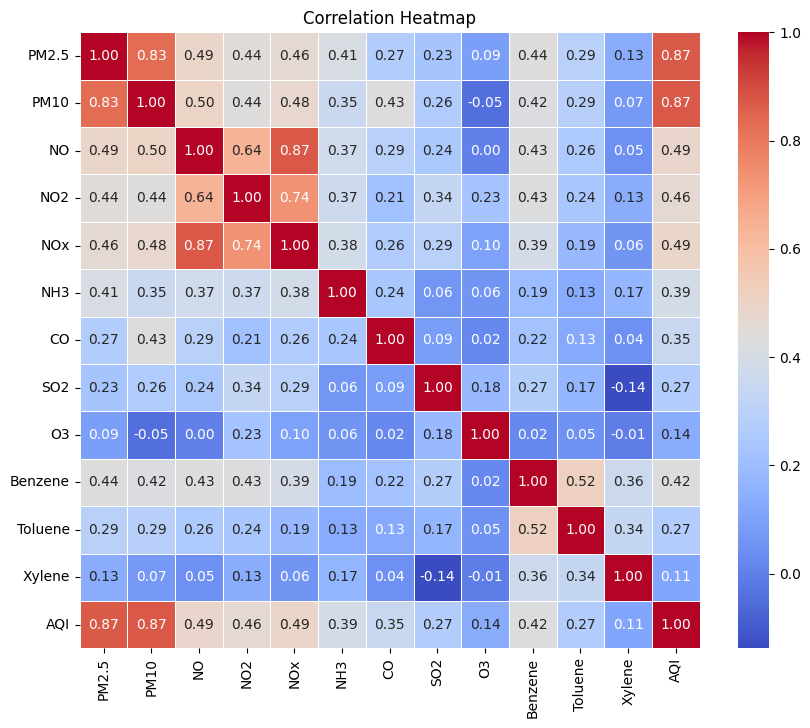

In [4]:
plt.figure(figsize=(10, 8))

# Select only numeric columns
numeric_df = df.select_dtypes(include=['number'])

correlation_matrix = numeric_df.corr()

sns.heatmap(
    correlation_matrix,
    annot=True,
    cmap="coolwarm",
    fmt=".2f",
    linewidths=0.5
)

plt.title("Correlation Heatmap")
plt.show()


In [5]:
df.isnull().sum()


,0
City,0
Date,0
PM2.5,276
PM10,4761
NO,455
NO2,445
NOx,297
NH3,9512
CO,1174
SO2,7603


In [6]:
# Drop columns with too many missing values
df = df.drop(columns=["Xylene", "Toluene", "Benzene", "SO2", "NH3"])

# Then drop remaining rows with small missing values
df = df.dropna()


In [7]:
df.isnull().sum()

,0
City,0
Date,0
PM2.5,0
PM10,0
NO,0
NO2,0
NOx,0
CO,0
O3,0
AQI,0


In [8]:
print("Final dataset shape:", df.shape)


Final dataset shape: (30224, 11)


In [9]:
# Features (only pollutants)
X = df[["PM2.5", "PM10", "NO", "NO2", "NOx", "CO", "O3"]]

# Target
y = df["AQI"]


In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [11]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [12]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

lr_pred = lr.predict(X_test_scaled)


In [15]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(
    n_estimators=400,
    max_depth=20,
    min_samples_split=5,
    random_state=42
)


rf.fit(X_train, y_train)

rf_pred = rf.predict(X_test)


In [23]:
from xgboost import XGBRegressor

xgb = XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    random_state=42
)

xgb.fit(X_train, y_train)

xgb_pred = xgb.predict(X_test)


In [24]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

def evaluate(y_true, y_pred, name):
    print(f"----- {name} -----")
    print("MAE :", round(mean_absolute_error(y_true, y_pred), 2))
    print("RMSE:", round(np.sqrt(mean_squared_error(y_true, y_pred)), 2))
    print("R2  :", round(r2_score(y_true, y_pred), 4))
    print()

evaluate(y_test, lr_pred, "Linear Regression")
evaluate(y_test, rf_pred, "Random Forest")
evaluate(y_test, xgb_pred, "XGBoost")



----- Linear Regression -----
MAE : 37.78
RMSE: 50.53
R2  : 0.8486

----- Random Forest -----
MAE : 24.71
RMSE: 37.23
R2  : 0.9178

----- XGBoost -----
MAE : 24.47
RMSE: 36.63
R2  : 0.9205



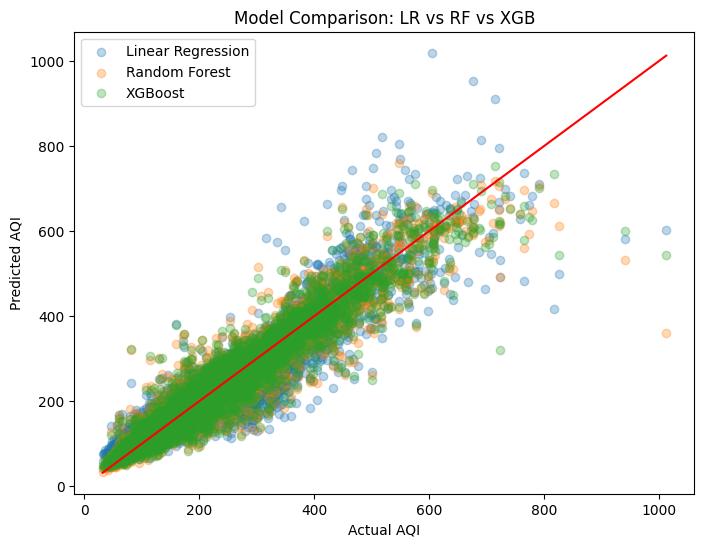

In [25]:
plt.figure(figsize=(8,6))

# Linear Regression
plt.scatter(y_test, lr_pred, alpha=0.3, label="Linear Regression")

# Random Forest
plt.scatter(y_test, rf_pred, alpha=0.3, label="Random Forest")

# XGBoost
plt.scatter(y_test, xgb_pred, alpha=0.3, label="XGBoost")

# Perfect prediction line
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         color='red')

plt.xlabel("Actual AQI")
plt.ylabel("Predicted AQI")
plt.title("Model Comparison: LR vs RF vs XGB")
plt.legend()
plt.show()


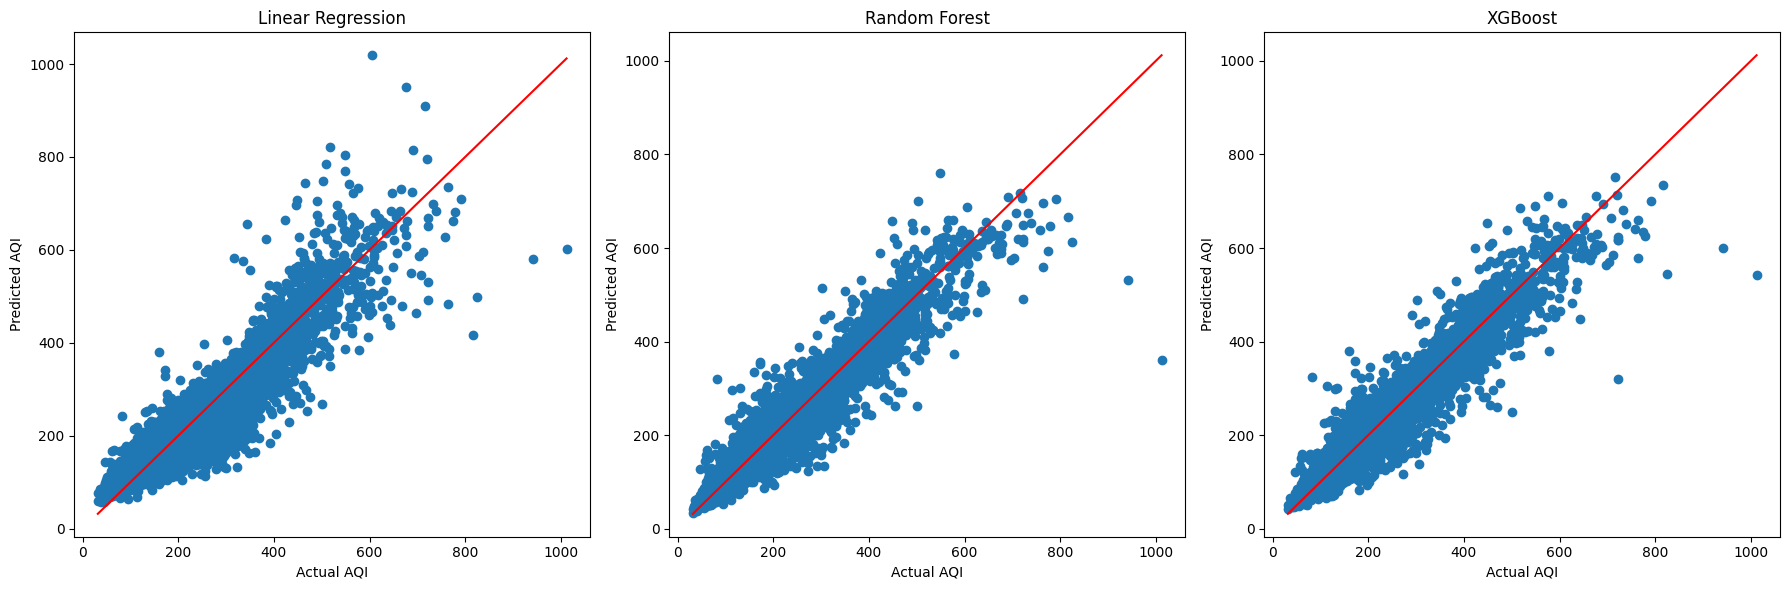

In [26]:
fig, axes = plt.subplots(1, 3, figsize=(18,6))

# Linear Regression
axes[0].scatter(y_test, lr_pred)
axes[0].plot([y_test.min(), y_test.max()],
             [y_test.min(), y_test.max()],
             color='red')
axes[0].set_title("Linear Regression")
axes[0].set_xlabel("Actual AQI")
axes[0].set_ylabel("Predicted AQI")

# Random Forest
axes[1].scatter(y_test, rf_pred)
axes[1].plot([y_test.min(), y_test.max()],
             [y_test.min(), y_test.max()],
             color='red')
axes[1].set_title("Random Forest")
axes[1].set_xlabel("Actual AQI")
axes[1].set_ylabel("Predicted AQI")

# XGBoost
axes[2].scatter(y_test, xgb_pred)
axes[2].plot([y_test.min(), y_test.max()],
             [y_test.min(), y_test.max()],
             color='red')
axes[2].set_title("XGBoost")
axes[2].set_xlabel("Actual AQI")
axes[2].set_ylabel("Predicted AQI")

plt.tight_layout()
plt.show()


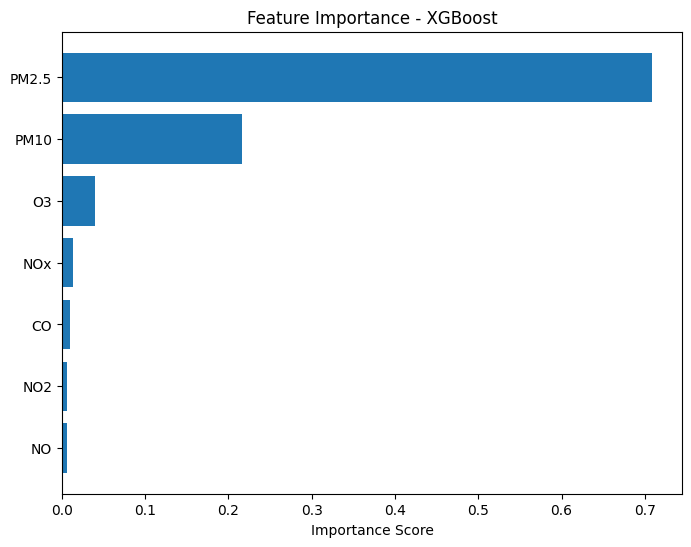

In [27]:
import matplotlib.pyplot as plt
import pandas as pd

importance = xgb.feature_importances_
features = X.columns

importance_df = pd.DataFrame({
    "Feature": features,
    "Importance": importance
}).sort_values(by="Importance", ascending=False)

plt.figure(figsize=(8,6))
plt.barh(importance_df["Feature"], importance_df["Importance"])
plt.gca().invert_yaxis()
plt.title("Feature Importance - XGBoost")
plt.xlabel("Importance Score")
plt.show()


In [28]:
import joblib

joblib.dump(xgb, "aqi_xgboost_model.pkl")


['aqi_xgboost_model.pkl']

In [29]:
from google.colab import files
files.download("aqi_xgboost_model.pkl")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>